# Forecasting vegetation condition  <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule),

## Background

This notebook conducts time-series forecasting of vegetation condition (NDVI) using SARIMAX, a variation on [autoregressive-moving-average (ARMA)](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model#ARMAX) models which includes an integrated (I) component to difference the timeseries so it becomes stationary, a seasonal (S) component, and has the capacity to consider exogenous (X) variables. 

In this example, we will conduct a forecast on a univariate NDVI timeseries. That is, our forecast will be built on temporal patterns in NDVI. Conversely, multivariate approaches can account for influences of variables such as soil moisture and rainfall.

## Description

In this notebook, we generate a NDVI timeseries from Sentinel-2, then use it develop a forecasting algorithm.

The following steps are taken:

1. Load Sentinel-2 data and calculate NDVI.
2. Iterate through SARIMAX parameters and conduct model selection based on cross-validation.
3. Inspect model diagnostics
4. Forecast NDVI into the future and visualise the result.

***

### Load packages
Import Python packages that are used for the analysis.

**Important note:** Scipy has updated and has some incompatibilities with old versions of statsmodels. If the loading packages cell below returns an error, try running `pip install statsmodels` or `pip install statsmodels --upgrade` in a code cell, then load the packages again.


In [1]:
%matplotlib inline
import datacube
import xarray as xr
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
from itertools import product
from datacube import Datacube
from matplotlib import pyplot as plt

from dea_tools.datahandling import load_ard
from dea_tools.plotting import display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster

from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.api import SARIMAX

## Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/git/dea-notebooks/Real_world_examples/dask-worker-space/worker-rrom7vrc', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/chad.burton@ga.gov.au/proxy/8787/status,
Dashboard: /user/chad.burton@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38571,Workers: 1
Dashboard: /user/chad.burton@ga.gov.au/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:41941,Total threads: 2
Dashboard: /user/chad.burton@ga.gov.au/proxy/45023/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:41571,


### Connect to the datacube

In [3]:
dc = datacube.Datacube(app="NDVI_forecast")

## Analysis parameters

* `lat`, `lon`: The central latitude and longitude to analyse. In this example we'll use an agricultural field near Esperance, WA.
* `buffer`: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as 0.1 or lower.
* `products`: The satellite data to load, in the example we will use Sentinel-2
* `time_range`: The date range to analyse. The longer the date-range, the more data the model have to derive patterns in the NDVI timeseries.
* `freq`: The frequency we want to resample the time-series to e.g. for monthly time steps use `'1M'`, for fortinightly use `'2W'`.
* `forecast_length`: The length of time beyond the latest observation in the dataset that we want the model to forecast, expressed in units of resample frequency `freq`. A longer `forecast_length` means greater forecast uncertainty. 
* `resolution`: The pixel resolution (in metres) to use for loading Sentinel-2
* `dask_chunks`: How to chunk the datasets to work with dask.

In [4]:
# Define the analysis region (Lat-Lon box)
lat, lon = -33.463, 121.472 
buffer = 0.005

#the satellite product to load
products = "s2a_ard_granule", "s2b_ard_granule"

# Define the time window for defining the model
time_range = ('2019-01', '2022-08')

#resample frequency
freq='1M'

#number of time-steps to forecast (in units of `freq`)
forecast_length = 6

#resolution of Sentinel-2 pixels
resolution = (-20,20)

#dask chunk sizes
dask_chunks={'x':500, 'y':500, 'time':-1}

## Display analysis area on an interactive map

In [5]:
lon=(lon - buffer, lon + buffer)
lat=(lat - buffer, lat + buffer)

display_map(lon,lat)

## Load the satellite data

Using the parameters we defined above.

In [6]:
# set up a datcube query object
query = {'x': lon, 'y': lat,
         'time': time_range,
         'measurements':['nbart_red', 'nbart_nir_1'],
         'output_crs' :'EPSG:3577',
         'resolution' : resolution,
         'resampling' :{"fmask": "nearest", "*": "bilinear"}}

In [7]:
# load the satellite data
ds = load_ard(dc=dc, 
              dask_chunks=dask_chunks,
              products=products,
              **query)
print(ds)

Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Applying pixel quality/cloud mask
Returning 1062 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 1062, y: 60, x: 52)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01T02:06:37.098000 ... 2022-08...
  * y            (y) float64 -3.69e+06 -3.69e+06 ... -3.691e+06 -3.691e+06
  * x            (x) float64 -9.719e+05 -9.719e+05 ... -9.709e+05 -9.709e+05
    spatial_ref  int32 3577
Data variables:
    nbart_red    (time, y, x) float32 dask.array<chunksize=(1062, 60, 52), meta=np.ndarray>
    nbart_nir_1  (time, y, x) float32 dask.array<chunksize=(1062, 60, 52), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


## Calculate NDVI and clean the time-series


Afrter calculating NDVI, we will smooth and interpolate the data to ensure we working with a consistent time-series. This is a very important step in the workflow and there are many ways to smooth, interpolate, gap-fill, remove outliers, or curve-fit the data to ensure a consistent time-series. If not using the default example, you may have to define additional methods to those used here.

To do this we take two steps:

1. Resample the data to monthly time-steps using the mean
2. Calculate a rolling mean with a window of 4 steps

In [8]:
#calculate NDVI
ndvi = calculate_indices(ds, 'NDVI', drop=True, collection='ga_s2_1')

Dropping bands ['nbart_red', 'nbart_nir_1']


In [9]:
#resample and smooth
window=4

ndvi=ndvi.resample(time=freq).mean().rolling(time=window, min_periods=1, center=True).mean()

### Reduce the time-series to one dimension

In this example, we're generating a forecast on a simple 1D timeseries. This time-series represents the spatially averaged NDVI at each time-step in the series. 

In this step, all the calculations above are triggered and the dataset is brought into memory so this step can take a few minutes to complete.

In [10]:
ndvi=ndvi.mean(['x','y'])
ndvi = ndvi.NDVI.compute()

CPLReleaseMutex: Error = 1 (Operation not permitted)


#### Plot the NDVI timeseries

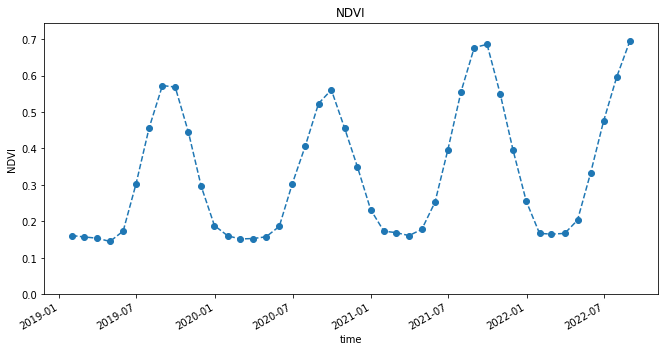

In [11]:
ndvi.plot(figsize=(11,5),linestyle='dashed', marker='o')
plt.title('NDVI')
plt.ylim(0,ndvi.max().values+0.05);

## Split data and fit a model

Cross-validation is a common method for evaluating model performance. It involves dividing data into a training set on which the model is trained, and test (or validation) set, to which the model is applied to produce predictions which are compared against actual values (that weren't used in model training).

In [12]:
ndvi = ndvi.drop('spatial_ref').to_dataframe()
train_data = ndvi['NDVI'][:len(ndvi)-10] # remove the last ten observations and keep them as test data
test_data = ndvi['NDVI'][len(ndvi)-10:]

## Iteratively find the best parameters for the SARIMAX model

SARIMAX models are fitted with parameters for both the trend and seasonal components of the timeseries. The parameters can be defined as:
* Trend elements
    * **p**: Autoregression order. This is the number of immediately preceding values in the series that are used to predict the value at the present time.
    * **d**: Difference order. The number of times that differencing is performed is called the difference order.
    * **q**: Moving average order. The size of the moving average window.
* Seasonal elements are as above, but for the seasonal component of the timeseries.
    * **P**
    * **D**
    * **Q**
* We also need to define the length of season.
    * **s**: In this case we use 6, which is in units of resample frequency so refers to 6 months.
    
In the cell below, initial values and a range are given for the parameters above. Using `range(0, 3)` means the values 0, 1, and 2 are iterated through for each of p, d, q and P, D, Q. This means that there are $3^2 \times 3^2 = 81$ possible combinations.

In [13]:
#Set initial values and some bounds
p = range(0, 3)
d = 1
q = range(0, 3)
P = range(0, 3)
D = 1
Q = range(0, 3)
s = 6

#Create a list with all possible combinations of parameters
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print('Number of iterations to run:', len(parameters_list))

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
    Return an ordered (ascending RMSE) dataframe with parameters,
    corresponding AIC, and RMSE.

    parameters_list - list with (p, q, P, Q) tuples
    d - integration order
    D - seasonal integration order
    s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm(parameters_list):
        try:
            import warnings
            warnings.filterwarnings("ignore")
            model = SARIMAX(train_data, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
            
            pred = model.predict(start=len(train_data), end=(len(ndvi)-1))
            error = rmse(pred, test_data)
        
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic, error])
        
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic', 'error']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='error', ascending=True).reset_index(drop=True)
    
    return result_table


Number of iterations to run: 81


Now will will run the function above for every iteration of parameters we have defined.  Depending on the number of iterations, this can take a few minutes to run. A progress bar is printed below.

In [14]:
#run the function above
result_table = optimize_SARIMA(parameters_list, d, D, s)

  0%|          | 0/81 [00:00<?, ?it/s]

## Model selection

The root-mean-square error (RMSE) is a common metric used to evaluate model or forecast performance. It is the standard deviation of residuals (difference between forecast and actual value) expressed in units of the variable of interest e.g. NDVI. We can calculate RMSE of our forecast because we withheld some observations as test or validation data.

We can also use either the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) or [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion) for model selection. Both these criteria aim to optimise the trade-off between goodness of fit and model simplicity. We are aiming to find the model that can explain the most variation in the timeseries with the least complexity, as added complexity may lead to overfitting. The BIC penalises additional parameters (greater complexity) more than the AIC. 

There are different schools of thought on which criterion to use. A general rule of thumb is that the BIC should be used for inference and interpretation whereas the AIC should be used for prediction. As our goal is prediction (forecasting), we could select the model with the lowest AIC, though this approach is often reserved for when there is no test data available for cross-validation.

The cell below presents the top 15 models based on AIC and the RMSE on the cross-validation.

In [15]:
#Sort table by the lowest AIC (Akaike Information Criteria) where the RMSE is low
result_table = result_table.sort_values('aic').sort_values('error')
print(result_table[0:15])

      parameters         aic     error
0   (2, 2, 1, 1) -101.928615  0.026157
1   (2, 2, 0, 2) -103.169189  0.028715
2   (0, 0, 1, 1)  -85.635462  0.031760
3   (2, 2, 0, 1) -104.359624  0.032651
4   (2, 2, 2, 2)  -99.661600  0.036288
5   (1, 2, 1, 1)  -91.466786  0.036554
6   (2, 2, 2, 1)  -98.944353  0.037350
7   (0, 1, 1, 1)  -95.222395  0.038418
8   (0, 2, 1, 1)  -93.537754  0.042630
9   (2, 1, 2, 1)  -93.898163  0.043233
10  (1, 2, 1, 0)  -94.515152  0.043242
11  (0, 0, 1, 2)  -76.617520  0.044443
12  (1, 0, 1, 1)  -93.820376  0.044763
13  (2, 2, 1, 2) -100.188381  0.045479
14  (1, 0, 2, 1)  -95.745633  0.045579


### Select model and predict

In the cell below. We select a model from the list above. In this case we've selected model `0` as it has the lowest RMSE, though you can select any model by setting the index number in the cell below using the `model_sel_index` parameter.

In [16]:
#selected model
model_sel_index = 0

#store parameters from selected model
p, q, P, Q = result_table.iloc[model_sel_index].parameters
print(result_table.iloc[model_sel_index])

#fit the model with the parameters identified above
best_model = SARIMAX(train_data, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)


parameters    (2, 2, 1, 1)
aic            -101.928615
error             0.026157
Name: 0, dtype: object


### Plot model diagnostics

There are some typical plots we can use to evaluate our model. 

1. **Standardised residuals (top-left)**
    The standardised residuals are plotted against x (time) values. This allows us to check that variance (distance of residuals from 0) is constant across time values. There should be no obvious patterns.
    
2. **Histogram and estimated density (top-right)**
    A kernel density estimation (KDE) is an estimated probability density function fitted on the actual distribution (histogram) of standardised residuals. A normal distribution (N (0,1)) is shown for reference. This plot shows that the distribution of our standardised residuals is close to normally distributed.
    
3. **Normal quantile-quantile (Q-Q) plot (bottom-left)**
     This plot shows 'expected' or 'theoretical' quantiles drawn from a normal distribution on the x-axis against quantiles taken from the sample of residuals on the y-axis. If the observations in blue match the 1:1 line in red, then we can conclude that our residuals are normally distributed.
     
4. **Correlogram (bottom-right)**
    The correlations for lags greater than 0 should not be statistically significant. That is, they should not be outside the blue ribbon.
    
> Note: The Q-Q plot and correlogram generated for model `0` show there is some pattern in the residuals. That is, there is remaining variation in the data which the model has not accounted for. You could experiment with different parameter values or model selection in the prior steps to see if this can be addressed.

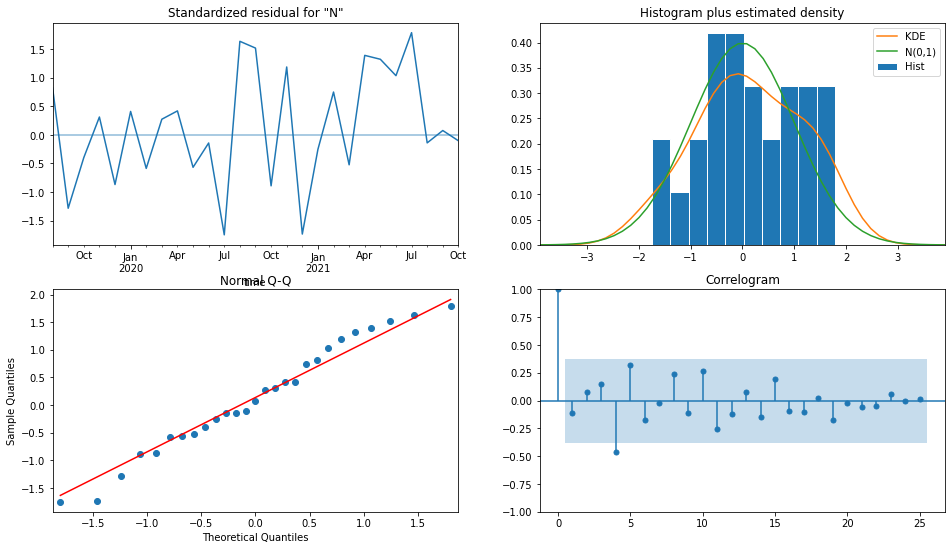

In [17]:
fig = plt.figure(figsize=(16, 9))
fig = best_model.plot_diagnostics(lags=25, fig=fig)

## Backtest forecast

We saved the last 10 observations as test data above. Now we can use our model to predict NDVI for those time-steps and compare those predictions with actual values. We can do this visually in the graph below and also quantify the error with the root-mean-square error (RMSE).

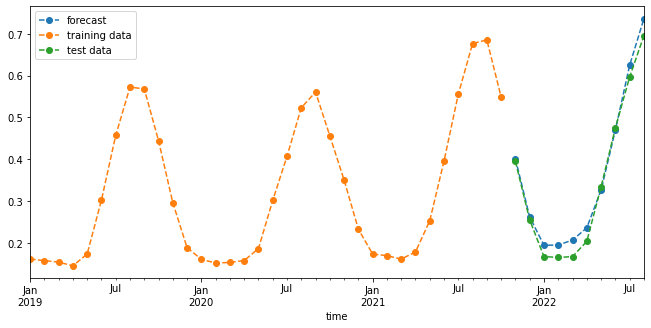

In [18]:
pred = best_model.predict(start=len(train_data), end=(len(ndvi)-1))

plt.figure(figsize=(11,5))
pred.plot(label='forecast', linestyle='dashed', marker='o')
train_data.plot(label='training data', linestyle='dashed', marker='o')
test_data.plot(label='test data', linestyle='dashed', marker='o')
plt.legend(loc="upper left");

## Plot the result of our forecast

To forecast NDVI into the future, we'll run a model on the entire time series so we can include the latest observations. We can see that the forecast uncertainty, expressed as the 95% confidence interval, increases with time.

In [19]:
final_model = SARIMAX(ndvi, order=(p, d, q), easonal_order=(P, D, Q, s)).fit(disp=-1)

yhat = final_model.get_forecast(forecast_length);

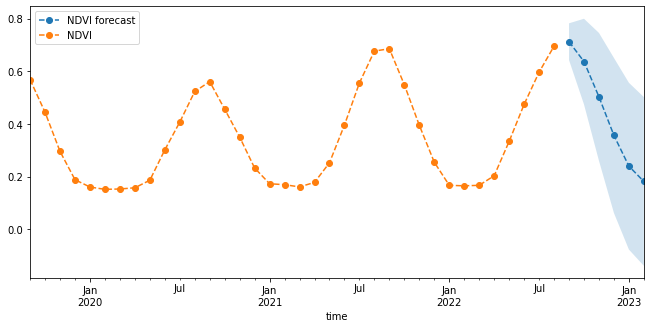

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
yhat.predicted_mean.plot(label="NDVI forecast", ax=ax, linestyle="dashed", marker="o")
ax.fill_between(
    yhat.predicted_mean.index,
    yhat.conf_int()["lower NDVI"],
    yhat.conf_int()["upper NDVI"],
    alpha=0.2,
)
ndvi[-36:].plot(label="Observations", ax=ax, linestyle="dashed", marker="o")
plt.legend(loc="upper left");

Our forecast looks reasonable in the context of the timeseries above. 

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2023

**Compatible datacube version:** 

In [21]:
print(datacube.__version__)

1.8.6


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)